# Team Assignment - Intentionally Blank

The following libraries should be installed before proceeding further:
- pandas
- numpy

In [1]:
#Import all necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import haversine as hs
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In addition to the available datasets from the team assignment the original dataset is read for additional information about each ride. The additional information contains the geographical coordinates for the start position and the end position of each ride.

In [2]:
# Reading in weather and philadelphia_2017 data
df_weather = pd.read_csv("data/weather_hourly_philadelphia.csv")
df_philadelphia_2017 = pd.read_csv("data/philadelphia_2017.csv")

# Additionally read the philadelphia data from the official website
data_philadelphia_2017_Q1 = pd.read_csv("data/indego_Q1_2017.csv")
data_philadelphia_2017_Q2 = pd.read_csv("data/indego_Q2_2017.csv")
data_philadelphia_2017_Q3 = pd.read_csv("data/indego_Q3_2017.csv")
data_philadelphia_2017_Q4 = pd.read_csv("data/indego_Q4_2017.csv")

## Preparing and cleaning data

### Preparing and cleaning the philadelphia datasets

In [3]:
# Concatenate all quarters of philadelphia data and convert them to a dataframe
df_philadelphia_website = pd.concat([data_philadelphia_2017_Q1, data_philadelphia_2017_Q2, data_philadelphia_2017_Q3, data_philadelphia_2017_Q4], ignore_index=True)

In [4]:
# Dropping the columns duration, start_station_id, end_station_id, plan_duration, trip_route_category, passholder_type, start_station, end_station
df_philadelphia_website.drop(['duration', 'start_station_id', 'end_station_id', 'plan_duration', 'trip_route_category', 'passholder_type', 'start_station', 'end_station', 'trip_id'], axis=1, inplace=True)
df_philadelphia_website

#Changing the type of start_time, end_time (df_philadelphia_2017 and df_philadelphia_website) and date_time (df_weather) to datetime type from pandas
df_philadelphia_website.loc[:,'start_time'] = pd.to_datetime(df_philadelphia_website['start_time'])
df_philadelphia_website.loc[:,'end_time'] = pd.to_datetime(df_philadelphia_website['end_time'])

df_philadelphia_2017.loc[:,'start_time'] = pd.to_datetime(df_philadelphia_2017['start_time'])
df_philadelphia_2017.loc[:,"end_time"] = pd.to_datetime(df_philadelphia_2017["end_time"])

#Sort dataframes by their corresponding time column
df_philadelphia_website.sort_values(["start_time"], inplace = True)
df_philadelphia_2017.sort_values(["start_time"], inplace = True)


#Resetting the indexes
df_philadelphia_website.reset_index(drop = True, inplace = True)
df_philadelphia_2017.reset_index(drop = True, inplace = True)

C:\Users\Paulo\AppData\Local\Temp\ipykernel_3980\495290899.py:6: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_philadelphia_website.loc[:,'start_time'] = pd.to_datetime(df_philadelphia_website['start_time'])
C:\Users\Paulo\AppData\Local\Temp\ipykernel_3980\495290899.py:7: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_philadelphia_website.loc[:,'end_time'] = pd.to_datetime(df_philadelphia_website['end_time'])
C:\Users\Paulo\AppData\Local\Temp\ipykernel_3980\495290899.py:9: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attemp

Before we further clean the dataset for philadelphia its important to mention that we first deleted the irrelevant stations because some duplicate rows happen to have the same start time, end time and bike ids but different start and end stations like the "Virtual Station". Therefore we deleted those stations first to avoid deleting useful records. In the following example you can see that deleting the duplicates first could lead to deleting useful records and keeping irrelevant records which are deleted either way later.

In [5]:
df_philadelphia_2017[df_philadelphia_2017.duplicated(subset=['start_time', 'end_time', 'bike_id'], keep=False)].head(6)

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name
255753,2017-06-05 15:26:00,2017-06-05 15:27:00,3152,3152,11907,Indego30,"40th & Baltimore, Trolley Portal","40th & Baltimore, Trolley Portal"
255755,2017-06-05 15:26:00,2017-06-05 15:27:00,3000,3000,11907,Indego30,Virtual Station,Virtual Station
256143,2017-06-05 17:26:00,2017-06-05 17:31:00,3152,3024,11907,Walk-up,"40th & Baltimore, Trolley Portal","43rd & Chester, Clark Park"
256148,2017-06-05 17:26:00,2017-06-05 17:31:00,3000,3024,11907,Walk-up,Virtual Station,"43rd & Chester, Clark Park"
258113,2017-06-06 16:02:00,2017-06-06 16:33:00,3004,3000,5314,Indego30,Municipal Services Building Plaza,Virtual Station
258115,2017-06-06 16:02:00,2017-06-06 16:33:00,3004,3161,5314,Indego30,Municipal Services Building Plaza,30th Street Station East


The "3083" station does not exist as a real station. Furthermore the "Virtual Station" is used by staff to check in or check out a bike remotely for an event or when the bike was not properly checked in or out. Therefore we check the number of rows where one of those stations occur and delete those rows afterwards.

For further information please check the official site about the data and the station table [here](https://www.rideindego.com/about/data/).

In [6]:
print(r'Number of rows in df_philadelphia_2017 with "Virtual Station" and "3083" in the start station or end station: ',
 df_philadelphia_2017[(df_philadelphia_2017["start_station_name"] == "Virtual Station") | (df_philadelphia_2017["end_station_name"] == "Virtual Station") |
  (df_philadelphia_2017["start_station_name"] == "3083") | (df_philadelphia_2017["end_station_name"] == "3083")
  ].shape[0])

Number of rows in df_philadelphia_2017 with "Virtual Station" and "3083" in the start station or end station:  6512


In [7]:
# Deleting "Virtual Station" and "3083" from the start_station_name and end_station_name columns
df_philadelphia_2017 = df_philadelphia_2017[(df_philadelphia_2017["start_station_name"] != "3083") & (df_philadelphia_2017["end_station_name"] != "3083") ]
df_philadelphia_2017 = df_philadelphia_2017[(df_philadelphia_2017["start_station_name"] != "Virtual Station") & (df_philadelphia_2017["end_station_name"] != "Virtual Station") ]

display(df_philadelphia_2017[(df_philadelphia_2017["start_station_name"] == "Virtual Station") | (df_philadelphia_2017["end_station_name"] == "Virtual Station") | (df_philadelphia_2017["start_station_name"] == "3083") | (df_philadelphia_2017["end_station_name"] == "3083")])

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name


The "bike_id" should be unique to one bike. No trip with the same bike_id should start and end on the same time interval. 

In [8]:
#Checking for any duplicates in philadelphia data
print("Number of duplicates in df_philadelphia_2017: ", df_philadelphia_2017.duplicated(subset=['start_time', 'end_time', 'bike_id']).sum())
print("Number of duplicates in df_philadelphia_website: ", df_philadelphia_website.duplicated(subset=['start_time', 'end_time', 'bike_id']).sum())

Number of duplicates in df_philadelphia_2017:  55
Number of duplicates in df_philadelphia_website:  68


In [9]:
#Dropping all duplicates for the philadelphia data depending on the start_time, end_time and bike_id
df_philadelphia_2017.drop_duplicates(subset=["start_time", "end_time", "bike_id"], keep="first", inplace=True)
df_philadelphia_website.drop_duplicates(subset=["start_time", "end_time", "bike_id"], keep="first", inplace=True)

display(df_philadelphia_2017[df_philadelphia_2017.duplicated(subset=['start_time', 'end_time', 'bike_id'])].head(10))
display(df_philadelphia_website[df_philadelphia_website.duplicated(subset=['start_time', 'end_time', 'bike_id'])].head(10))

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name


,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id


In [10]:
# Joining df_philadelphia_2017 with df_philadelphia_full on start_time, end_time, bike_id and dropping duplicate columns
df_philadelphia_2017_joined = df_philadelphia_2017.merge(df_philadelphia_website, on=["start_time", "end_time", "bike_id"], how="left")

df_philadelphia_2017_joined

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon
0,2017-01-01 00:05:00,2017-01-01 00:16:00,3046,3041,5347,Indego30,2nd & Market,"Girard Station, MFL",39.950119,-75.144722,39.968491,-75.135460
1,2017-01-01 00:21:00,2017-01-01 00:57:00,3110,3054,3364,Walk-up,Del. River Trail & Penn St.,Rodin Museum,39.961750,-75.136414,39.962502,-75.174202
2,2017-01-01 00:22:00,2017-01-01 00:57:00,3110,3054,2536,Walk-up,Del. River Trail & Penn St.,Rodin Museum,39.961750,-75.136414,39.962502,-75.174202
3,2017-01-01 00:27:00,2017-01-01 00:39:00,3041,3005,5176,Indego30,"Girard Station, MFL","Welcome Park, NPS",39.968491,-75.135460,39.947330,-75.144028
4,2017-01-01 00:28:00,2017-01-01 00:36:00,3047,3124,5370,Walk-up,"Independence Mall, NPS",Race Street Pier,39.950710,-75.149208,39.952950,-75.139793
...,...,...,...,...,...,...,...,...,...,...,...,...
782335,2017-12-31 23:05:00,2017-12-31 23:33:00,3070,3124,3708,Indego30,"Spring Garden Station, MFL",Race Street Pier,39.960621,-75.139832,39.952950,-75.139793
782336,2017-12-31 23:11:00,2018-01-01 11:03:00,3107,3165,5117,Indego30,33rd & Reservoir,24th & Race SRT,39.982029,-75.188660,39.958191,-75.178200
782337,2017-12-31 23:18:00,2017-12-31 23:25:00,3033,3046,11933,Indego30,10th & Chestnut,2nd & Market,39.950050,-75.156723,39.950119,-75.144722
782338,2017-12-31 23:39:00,2017-12-31 23:40:00,3163,3163,6725,Indego30,25th & Locust,25th & Locust,39.949741,-75.180969,39.949741,-75.180969


In [11]:
#Checking for missing values in philadelphia data
display(df_philadelphia_2017_joined[df_philadelphia_2017_joined.isnull().any(axis = 1)])

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon
255784,2017-06-06 16:02:00,2017-06-06 16:33:00,3004,3161,5314,Indego30,Municipal Services Building Plaza,30th Street Station East,39.953781,-75.163742,NaN,NaN
613438,2017-10-05 08:35:00,2017-10-05 08:47:00,3111,3107,5306,Indego30,"Parkside & Belmont, Case Building",33rd & Reservoir,NaN,NaN,39.982029,-75.18866
613848,2017-10-05 10:31:00,2017-10-05 10:53:00,3095,3111,5329,Indego30,29th & Diamond,"Parkside & Belmont, Case Building",39.987709,-75.180519,NaN,NaN


In [12]:
df_philadelphia_2017_joined.dropna(inplace = True)	

In [13]:
#Adding hour, month, weekday and trip duration(based on start and end time) to the table
df_philadelphia_2017_joined.loc[:,"trip_duration"] = df_philadelphia_2017_joined["end_time"] - df_philadelphia_2017_joined["start_time"] 
df_philadelphia_2017_joined.loc[:,"month"] = df_philadelphia_2017_joined["start_time"].dt.month
df_philadelphia_2017_joined.loc[:,"week"] = df_philadelphia_2017_joined["start_time"].dt.isocalendar().week
df_philadelphia_2017_joined.loc[:,"weekday"] = df_philadelphia_2017_joined["start_time"].dt.weekday
df_philadelphia_2017_joined.loc[:,"day"] = df_philadelphia_2017_joined["start_time"].dt.day
df_philadelphia_2017_joined.loc[:,"hour"] = df_philadelphia_2017_joined["start_time"].dt.hour
df_philadelphia_2017_joined

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon,trip_duration,month,week,weekday,day,hour
0,2017-01-01 00:05:00,2017-01-01 00:16:00,3046,3041,5347,Indego30,2nd & Market,"Girard Station, MFL",39.950119,-75.144722,39.968491,-75.135460,0 days 00:11:00,1,52,6,1,0
1,2017-01-01 00:21:00,2017-01-01 00:57:00,3110,3054,3364,Walk-up,Del. River Trail & Penn St.,Rodin Museum,39.961750,-75.136414,39.962502,-75.174202,0 days 00:36:00,1,52,6,1,0
2,2017-01-01 00:22:00,2017-01-01 00:57:00,3110,3054,2536,Walk-up,Del. River Trail & Penn St.,Rodin Museum,39.961750,-75.136414,39.962502,-75.174202,0 days 00:35:00,1,52,6,1,0
3,2017-01-01 00:27:00,2017-01-01 00:39:00,3041,3005,5176,Indego30,"Girard Station, MFL","Welcome Park, NPS",39.968491,-75.135460,39.947330,-75.144028,0 days 00:12:00,1,52,6,1,0
4,2017-01-01 00:28:00,2017-01-01 00:36:00,3047,3124,5370,Walk-up,"Independence Mall, NPS",Race Street Pier,39.950710,-75.149208,39.952950,-75.139793,0 days 00:08:00,1,52,6,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782335,2017-12-31 23:05:00,2017-12-31 23:33:00,3070,3124,3708,Indego30,"Spring Garden Station, MFL",Race Street Pier,39.960621,-75.139832,39.952950,-75.139793,0 days 00:28:00,12,52,6,31,23
782336,2017-12-31 23:11:00,2018-01-01 11:03:00,3107,3165,5117,Indego30,33rd & Reservoir,24th & Race SRT,39.982029,-75.188660,39.958191,-75.178200,0 days 11:52:00,12,52,6,31,23
782337,2017-12-31 23:18:00,2017-12-31 23:25:00,3033,3046,11933,Indego30,10th & Chestnut,2nd & Market,39.950050,-75.156723,39.950119,-75.144722,0 days 00:07:00,12,52,6,31,23
782338,2017-12-31 23:39:00,2017-12-31 23:40:00,3163,3163,6725,Indego30,25th & Locust,25th & Locust,39.949741,-75.180969,39.949741,-75.180969,0 days 00:01:00,12,52,6,31,23


We also remove trips which are shorter than one minute and longer than one day because the bike sharing service does not allow those trips normally.

In [14]:
df_philadelphia_2017_joined[df_philadelphia_2017_joined["trip_duration"] < "0 days 00:01:00"]

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon,trip_duration,month,week,weekday,day,hour
699155,2017-11-05 01:35:00,2017-11-05 01:03:00,3118,3111,6694,Indego30,"46th Street Station, MFL","Parkside & Belmont, Case Building",39.958660,-75.213226,39.977791,-75.213226,-1 days +23:28:00,11,44,6,5,1
699158,2017-11-05 01:39:00,2017-11-05 01:35:00,3066,3066,2551,Indego30,19th & Lombard,19th & Lombard,39.945610,-75.173477,39.945610,-75.173477,-1 days +23:56:00,11,44,6,5,1
699163,2017-11-05 01:51:00,2017-11-05 01:20:00,3157,3041,11750,Indego30,"8th & Mifflin, Bok Building","Girard Station, MFL",39.925449,-75.159538,39.968491,-75.135460,-1 days +23:29:00,11,44,6,5,1


In [15]:
df_philadelphia_2017_joined = df_philadelphia_2017_joined[df_philadelphia_2017_joined["trip_duration"] >= "0 days 00:01:00"]
df_philadelphia_2017_joined[df_philadelphia_2017_joined["trip_duration"] < "0 days 00:01:00"]

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon,trip_duration,month,week,weekday,day,hour


In [16]:
df_philadelphia_2017_joined[df_philadelphia_2017_joined["trip_duration"] > "1 days"]

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon,trip_duration,month,week,weekday,day,hour
682,2017-01-01 18:19:00,2017-01-03 08:04:00,3072,3125,5354,Walk-up,Front & Carpenter,15th & South,39.934448,-75.145409,39.943909,-75.167351,1 days 13:45:00,1,52,6,1,18
20987,2017-01-23 15:19:00,2017-01-24 16:14:00,3038,3028,2492,Indego30,The Children's Hospital of Philadelphia (CHOP),4th & Bainbridge,39.947811,-75.194092,39.940609,-75.149582,1 days 00:55:00,1,4,0,23,15
24873,2017-01-26 17:31:00,2017-01-28 10:00:00,3021,3109,5185,Indego30,18th & JFK,Parkside & Girard,39.953899,-75.169022,39.974861,-75.205238,1 days 16:29:00,1,4,3,26,17
27216,2017-01-28 15:46:00,2017-01-30 08:01:00,3012,3034,5255,Walk-up,21st & Catharine,11th & Reed,39.942181,-75.177467,39.933151,-75.162483,1 days 16:15:00,1,4,5,28,15
32762,2017-02-02 09:45:00,2017-02-03 17:59:00,3054,3021,5125,Indego30,Rodin Museum,18th & JFK,39.962502,-75.174202,39.953899,-75.169022,1 days 08:14:00,2,5,3,2,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735895,2017-11-25 12:12:00,2017-11-27 07:31:00,3112,3020,11894,Indego30,48th & Spruce,University City Station,39.953732,-75.218246,39.949219,-75.190361,1 days 19:19:00,11,47,5,25,12
749711,2017-12-02 13:00:00,2017-12-03 14:12:00,3040,3073,11928,Walk-up,17th & Spring Garden,9th & Spring Garden,39.962891,-75.166061,39.961430,-75.152420,1 days 01:12:00,12,48,5,2,13
763091,2017-12-11 11:46:00,2017-12-12 13:15:00,3018,3037,3367,Indego30,12th & Filbert,Pennsylvania Convention Center,39.952728,-75.159790,39.954239,-75.161377,1 days 01:29:00,12,50,0,11,11
768955,2017-12-15 19:27:00,2017-12-17 16:32:00,3026,3072,11932,Indego30,2nd & South,Front & Carpenter,39.941380,-75.145638,39.934448,-75.145409,1 days 21:05:00,12,50,4,15,19


In [17]:
df_philadelphia_2017_joined = df_philadelphia_2017_joined[df_philadelphia_2017_joined["trip_duration"] <= "1 days"]
df_philadelphia_2017_joined[df_philadelphia_2017_joined["trip_duration"] > "1 days"]

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon,trip_duration,month,week,weekday,day,hour


In [18]:
df_philadelphia_cleaned = df_philadelphia_2017_joined.copy()
df_philadelphia_cleaned

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon,trip_duration,month,week,weekday,day,hour
0,2017-01-01 00:05:00,2017-01-01 00:16:00,3046,3041,5347,Indego30,2nd & Market,"Girard Station, MFL",39.950119,-75.144722,39.968491,-75.135460,0 days 00:11:00,1,52,6,1,0
1,2017-01-01 00:21:00,2017-01-01 00:57:00,3110,3054,3364,Walk-up,Del. River Trail & Penn St.,Rodin Museum,39.961750,-75.136414,39.962502,-75.174202,0 days 00:36:00,1,52,6,1,0
2,2017-01-01 00:22:00,2017-01-01 00:57:00,3110,3054,2536,Walk-up,Del. River Trail & Penn St.,Rodin Museum,39.961750,-75.136414,39.962502,-75.174202,0 days 00:35:00,1,52,6,1,0
3,2017-01-01 00:27:00,2017-01-01 00:39:00,3041,3005,5176,Indego30,"Girard Station, MFL","Welcome Park, NPS",39.968491,-75.135460,39.947330,-75.144028,0 days 00:12:00,1,52,6,1,0
4,2017-01-01 00:28:00,2017-01-01 00:36:00,3047,3124,5370,Walk-up,"Independence Mall, NPS",Race Street Pier,39.950710,-75.149208,39.952950,-75.139793,0 days 00:08:00,1,52,6,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782335,2017-12-31 23:05:00,2017-12-31 23:33:00,3070,3124,3708,Indego30,"Spring Garden Station, MFL",Race Street Pier,39.960621,-75.139832,39.952950,-75.139793,0 days 00:28:00,12,52,6,31,23
782336,2017-12-31 23:11:00,2018-01-01 11:03:00,3107,3165,5117,Indego30,33rd & Reservoir,24th & Race SRT,39.982029,-75.188660,39.958191,-75.178200,0 days 11:52:00,12,52,6,31,23
782337,2017-12-31 23:18:00,2017-12-31 23:25:00,3033,3046,11933,Indego30,10th & Chestnut,2nd & Market,39.950050,-75.156723,39.950119,-75.144722,0 days 00:07:00,12,52,6,31,23
782338,2017-12-31 23:39:00,2017-12-31 23:40:00,3163,3163,6725,Indego30,25th & Locust,25th & Locust,39.949741,-75.180969,39.949741,-75.180969,0 days 00:01:00,12,52,6,31,23


### Preparing and cleaning the weather dataset

After preparing and cleaning the philadelphia dataset we need to do most of the procedure on the weather dataset.

In [19]:
#Changing the type of date_time (df_weather) to datetime type from pandas
df_weather.loc[:, "date_time"] = pd.to_datetime(df_weather["date_time"])

#Sort the dataframe by their corresponding time column
df_weather.sort_values(["date_time"], inplace = True)

#Reset the index
df_weather.reset_index(drop = True, inplace =True)

C:\Users\Paulo\AppData\Local\Temp\ipykernel_3980\1772864593.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_weather.loc[:, "date_time"] = pd.to_datetime(df_weather["date_time"])


First of all we check for duplicate rows in the weather data and delete them if they occur because we do not need multiple rows multiple times.

In [20]:
#Checking for any duplicates in weather data
print("Number of duplicates in df_weather: ", df_weather.duplicated().sum())

Number of duplicates in df_weather:  630


In [21]:
#Dropping all duplicates for the weather data
df_weather.drop_duplicates(subset= ["date_time"],inplace = True)

display(df_weather[df_weather.duplicated()])

,date_time,max_temp,min_temp,precip


We also check for null values in the weather data and delete them. It is important to note that we later add additional rows with null values but with the missing time intervals because we can interpolate them with the interpolate function in pandas.

In [22]:
#Checking for missing values in weather data
display(df_weather[df_weather.isnull().any(axis = 1)])

,date_time,max_temp,min_temp,precip
43785,NaT,NaN,NaN,NaN


In [23]:
df_weather.dropna(inplace = True)

Since the weather data consists of data from the beginning of 2015 until the end of 2019, we want to have as well only the weather data for 2017.

In [24]:
#Selecting data from the beginning of 2017 till the end of 2017
df_weather_2017 = df_weather[(df_weather["date_time"]>= "2017-01-01 00:00:00") & (df_weather["date_time"]< "2018-01-01 00:00:00" )]

In [25]:
#Add missing intervals in the weather data
df_weather_2017.set_index("date_time", inplace = True)
df_weather_2017 = df_weather_2017.resample("H").asfreq()

The minimum temperature and maximum temperature will be interpolated linearly. The precipitation value is interpolated by taking one of the nearest existing values.

In [26]:
# Interpolate missing values in the weather data
df_weather_2017["min_temp"].interpolate(method = "linear", inplace = True)
df_weather_2017["max_temp"].interpolate(method = "linear", inplace = True)
df_weather_2017["precip"].interpolate(method = "pad", inplace = True)
df_weather_2017.reset_index(drop=False, inplace = True)

# Check if null values in the weather data still exist
display(df_weather_2017[df_weather_2017.isnull().any(axis = 1)])
display(df_weather_2017)

,date_time,max_temp,min_temp,precip


,date_time,max_temp,min_temp,precip
0,2017-01-01 00:00:00,6.1,6.1,0.0
1,2017-01-01 01:00:00,6.1,6.1,0.0
2,2017-01-01 02:00:00,6.7,6.7,0.0
3,2017-01-01 03:00:00,7.2,7.2,0.0
4,2017-01-01 04:00:00,7.8,7.8,0.0
...,...,...,...,...
8755,2017-12-31 19:00:00,-8.9,-8.9,0.0
8756,2017-12-31 20:00:00,-8.9,-8.9,0.0
8757,2017-12-31 21:00:00,-9.4,-9.4,0.0
8758,2017-12-31 22:00:00,-10.0,-10.0,0.0


All dataframes for reference:
* **Philadelphia data**
   * *df_philadelphia_cleaned*
* **Weather data**
   * *df_weather_2017*

## Clustering

### Data Prep

In [29]:
df_philadelphia_cleaned.reset_index(inplace=True, drop=True) # Only done because its not done in the original data cleaning part, remove once happened

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon,trip_duration,month,week,weekday,day,hour
0,2017-01-01 00:05:00,2017-01-01 00:16:00,3046,3041,5347,Indego30,2nd & Market,"Girard Station, MFL",39.950119,-75.144722,39.968491,-75.135460,0 days 00:11:00,1,52,6,1,0
1,2017-01-01 00:21:00,2017-01-01 00:57:00,3110,3054,3364,Walk-up,Del. River Trail & Penn St.,Rodin Museum,39.961750,-75.136414,39.962502,-75.174202,0 days 00:36:00,1,52,6,1,0
2,2017-01-01 00:22:00,2017-01-01 00:57:00,3110,3054,2536,Walk-up,Del. River Trail & Penn St.,Rodin Museum,39.961750,-75.136414,39.962502,-75.174202,0 days 00:35:00,1,52,6,1,0
3,2017-01-01 00:27:00,2017-01-01 00:39:00,3041,3005,5176,Indego30,"Girard Station, MFL","Welcome Park, NPS",39.968491,-75.135460,39.947330,-75.144028,0 days 00:12:00,1,52,6,1,0
4,2017-01-01 00:28:00,2017-01-01 00:36:00,3047,3124,5370,Walk-up,"Independence Mall, NPS",Race Street Pier,39.950710,-75.149208,39.952950,-75.139793,0 days 00:08:00,1,52,6,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782220,2017-12-31 23:05:00,2017-12-31 23:33:00,3070,3124,3708,Indego30,"Spring Garden Station, MFL",Race Street Pier,39.960621,-75.139832,39.952950,-75.139793,0 days 00:28:00,12,52,6,31,23
782221,2017-12-31 23:11:00,2018-01-01 11:03:00,3107,3165,5117,Indego30,33rd & Reservoir,24th & Race SRT,39.982029,-75.188660,39.958191,-75.178200,0 days 11:52:00,12,52,6,31,23
782222,2017-12-31 23:18:00,2017-12-31 23:25:00,3033,3046,11933,Indego30,10th & Chestnut,2nd & Market,39.950050,-75.156723,39.950119,-75.144722,0 days 00:07:00,12,52,6,31,23
782223,2017-12-31 23:39:00,2017-12-31 23:40:00,3163,3163,6725,Indego30,25th & Locust,25th & Locust,39.949741,-75.180969,39.949741,-75.180969,0 days 00:01:00,12,52,6,31,23


In [30]:
# Calculating the distance between start and end coordinates of stations
for i in range(0, len(df_philadelphia_cleaned)):
    combined_start_coordinates = (df_philadelphia_cleaned.at[i, 'start_lat'], df_philadelphia_cleaned.at[i, 'start_lon'])
    combined_end_coordinates = (df_philadelphia_cleaned.at[i, 'end_lat'], df_philadelphia_cleaned.at[i, 'end_lon'])

    # By default haversine uses km, so no need to set extra units
    df_philadelphia_cleaned.at[i, 'distance_in_km'] = hs.haversine(combined_start_coordinates, combined_end_coordinates)

In [31]:
df_philadelphia_cleaned

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon,trip_duration,month,week,weekday,day,hour,distance_in_km
0,2017-01-01 00:05:00,2017-01-01 00:16:00,3046,3041,5347,Indego30,2nd & Market,"Girard Station, MFL",39.950119,-75.144722,39.968491,-75.135460,0 days 00:11:00,1,52,6,1,0,2.190094
1,2017-01-01 00:21:00,2017-01-01 00:57:00,3110,3054,3364,Walk-up,Del. River Trail & Penn St.,Rodin Museum,39.961750,-75.136414,39.962502,-75.174202,0 days 00:36:00,1,52,6,1,0,3.221666
2,2017-01-01 00:22:00,2017-01-01 00:57:00,3110,3054,2536,Walk-up,Del. River Trail & Penn St.,Rodin Museum,39.961750,-75.136414,39.962502,-75.174202,0 days 00:35:00,1,52,6,1,0,3.221666
3,2017-01-01 00:27:00,2017-01-01 00:39:00,3041,3005,5176,Indego30,"Girard Station, MFL","Welcome Park, NPS",39.968491,-75.135460,39.947330,-75.144028,0 days 00:12:00,1,52,6,1,0,2.463718
4,2017-01-01 00:28:00,2017-01-01 00:36:00,3047,3124,5370,Walk-up,"Independence Mall, NPS",Race Street Pier,39.950710,-75.149208,39.952950,-75.139793,0 days 00:08:00,1,52,6,1,0,0.840302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782220,2017-12-31 23:05:00,2017-12-31 23:33:00,3070,3124,3708,Indego30,"Spring Garden Station, MFL",Race Street Pier,39.960621,-75.139832,39.952950,-75.139793,0 days 00:28:00,12,52,6,31,23,0.852984
782221,2017-12-31 23:11:00,2018-01-01 11:03:00,3107,3165,5117,Indego30,33rd & Reservoir,24th & Race SRT,39.982029,-75.188660,39.958191,-75.178200,0 days 11:52:00,12,52,6,31,23,2.796533
782222,2017-12-31 23:18:00,2017-12-31 23:25:00,3033,3046,11933,Indego30,10th & Chestnut,2nd & Market,39.950050,-75.156723,39.950119,-75.144722,0 days 00:07:00,12,52,6,31,23,1.023025
782223,2017-12-31 23:39:00,2017-12-31 23:40:00,3163,3163,6725,Indego30,25th & Locust,25th & Locust,39.949741,-75.180969,39.949741,-75.180969,0 days 00:01:00,12,52,6,31,23,0.000000


In [32]:
# Making a copy to not destroy the original table
df_phil_clustering = df_philadelphia_cleaned.copy()

# Deleting every column except for a feature columns after calculating them
df_phil_clustering.drop(['start_time', 'end_time', 'start_station_id', 'end_station_id', 'bike_id', 'user_type', 'start_station_name', 'end_station_name', 
'start_lat', 'start_lon', 'end_lat', 'end_lon', 'month', 'week', 'weekday', 'day'], axis=1, inplace=True)
df_phil_clustering.loc[:, 'trip_duration'] = df_phil_clustering['trip_duration'].dt.seconds / 60
df_phil_clustering.rename(columns={'trip_duration': 'trip_duration in minutes'}, inplace=True)
df_phil_clustering['trip_duration in minutes'] = df_phil_clustering['trip_duration in minutes'].astype(int)

In [33]:
df_phil_clustering

,trip_duration in minutes,hour,distance_in_km
0,11,0,2.190094
1,36,0,3.221666
2,35,0,3.221666
3,12,0,2.463718
4,8,0,0.840302
...,...,...,...
782220,28,23,0.852984
782221,712,23,2.796533
782222,7,23,1.023025
782223,1,23,0.000000


### Functions to use for Clustering

In [34]:
# This function is used to standardize features
def scalingData(dataframe):
    scaler = StandardScaler()
    dataframe = pd.DataFrame(scaler.fit_transform(dataframe))
    dataframe.head()
    return dataframe

In [35]:
# This function calculates the Loss per cluster amount and plots the result of it in the range of 0-10 on the x-axis
def calcAndPlotLoss(clusterAmount, dataframe):
    k_max = clusterAmount

    clusters = []
    losses = []

    for k in range(k_max):
        model = KMeans(n_clusters=k+1)
        model.fit(dataframe)
        clusters.append(k+1)
        losses.append(model.inertia_)

    plt.plot(clusters, losses)
    plt.ylabel("Loss")
    plt.xlabel("Number of clusters")
    plt.xlim([0,10])
    plt.show()

In [36]:
# This function calculates for a the defined amount of clusters KMeans on the given dataframe
def calcKMeans(numClusters, dataframe):
    #numbers = [range(0, numClusters)]

    result = KMeans(n_clusters=numClusters)
    result.fit(dataframe)

    dataframe['KMeans'] = result.predict(dataframe)
    #dataframe['KMeans'] = dataframe['KMeans'].apply(lambda x: numbers[x])
    sns.pairplot(data=dataframe, hue='KMeans')

c:\python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

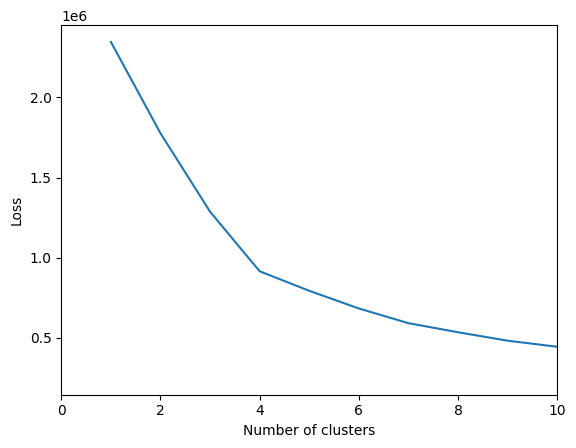

In [33]:
df_phil_clustering_scaled = scalingData(df_phil_clustering)
calcAndPlotLoss(20, df_phil_clustering_scaled)

c:\python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


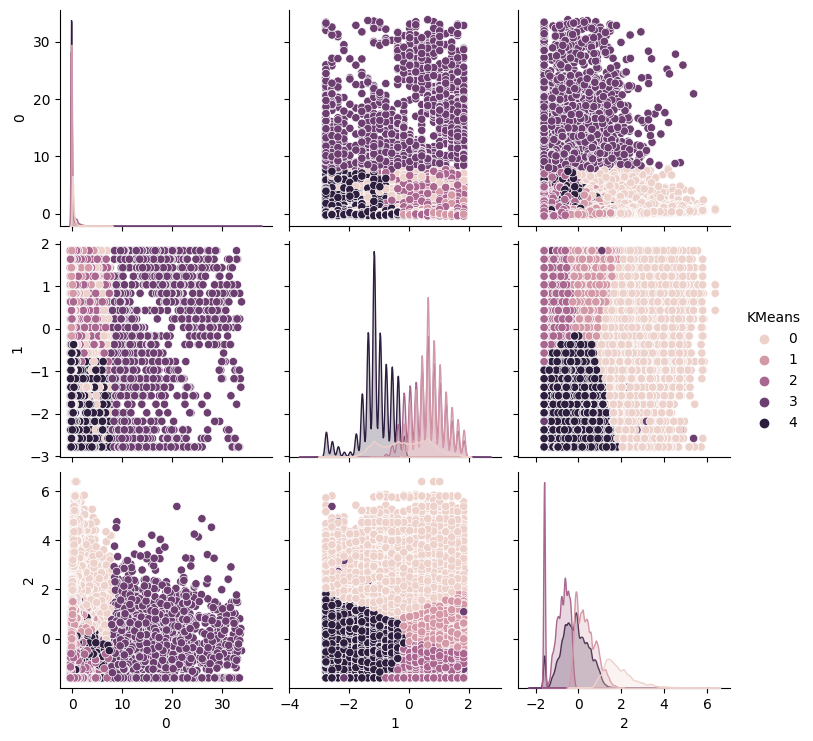

In [34]:
calcKMeans(5, df_phil_clustering_scaled)